## Importing Libarires

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import re
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pathlib
import random
import tensorflow as tf

## Demographics Data for MRI patients

#### Loading and Formatting Demographics Data

In [4]:
#Getting data directly from the source (OASIS Brain Data)
df = pd.read_excel('https://www.oasis-brains.org/files/oasis_longitudinal_demographics.xlsx')

In [5]:
#Mapping the values of Demented (CDR) into different categories.
group_mapping = {
    0.0: 'Non Demented',
    0.5: 'Mild Demented',
    1.0: 'Moderate Demented',
    2.0: 'Highly Demented'
}

df['Actual Group'] = df['CDR'].map(group_mapping)

df_demographics_input = df
df.head()

Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR         eTIV      nWBV       ASF   Actual Group  
0  2.0  27.0  0.0  1986.550000  0.696106  0.883440   Non Demented  
1  2.0  30.0  0.0  2004.479526  0.681062  0.875539   Non Demented  
2  NaN  23.0  0.5  1678.290000  0.736336  1.045710  Mild Demented  
3  NaN  28.0  0.5  1737.620000  0.713402  1.010000  Mild Demented  
4  NaN  22.0  0.5  1697.911134  0.701236  1.033623  Mild Demented

#### Analysis and Visulization of Demographics Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Subject ID    373 non-null    object 
 1   MRI ID        373 non-null    object 
 2   Group         373 non-null    object 
 3   Visit         373 non-null    int64  
 4   MR Delay      373 non-null    int64  
 5   M/F           373 non-null    object 
 6   Hand          373 non-null    object 
 7   Age           373 non-null    int64  
 8   EDUC          373 non-null    int64  
 9   SES           354 non-null    float64
 10  MMSE          371 non-null    float64
 11  CDR           373 non-null    float64
 12  eTIV          373 non-null    float64
 13  nWBV          373 non-null    float64
 14  ASF           373 non-null    float64
 15  Actual Group  373 non-null    object 
dtypes: float64(6), int64(4), object(6)
memory usage: 46.8+ KB


In [7]:
df.describe()

Visit     MR Delay         Age        EDUC         SES  \
count  373.000000   373.000000  373.000000  373.000000  354.000000   
mean     1.882038   595.104558   77.013405   14.597855    2.460452   
std      0.922843   635.485118    7.640957    2.876339    1.134005   
min      1.000000     0.000000   60.000000    6.000000    1.000000   
25%      1.000000     0.000000   71.000000   12.000000    2.000000   
50%      2.000000   552.000000   77.000000   15.000000    2.000000   
75%      2.000000   873.000000   82.000000   16.000000    3.000000   
max      5.000000  2639.000000   98.000000   23.000000    5.000000   

             MMSE         CDR         eTIV        nWBV         ASF  
count  371.000000  373.000000   373.000000  373.000000  373.000000  
mean    27.342318    0.290885  1488.121584    0.729556    1.195460  
std      3.683244    0.374557   176.135956    0.037141    0.138105  
min      4.000000    0.000000  1105.652499    0.644399    0.875539  
25%     27.000000    0.000000  1357.330000    0.700191    1.098979  
50%     29.000000    0.000000  1470.041312    0.728789    1.193844  
75%     30.000000    0.500000  1596.936793    0.755669    1.292980  
max     30.000000    2.000000  2004.479526    0.836842    1.587298

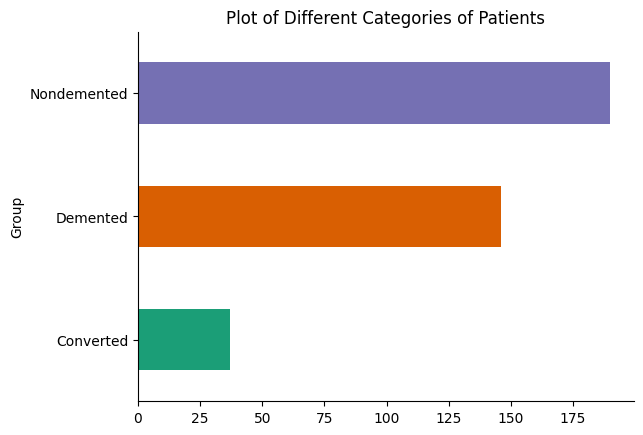

In [8]:
df.groupby('Group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title("Plot of Different Categories of Patients")
plt.show()

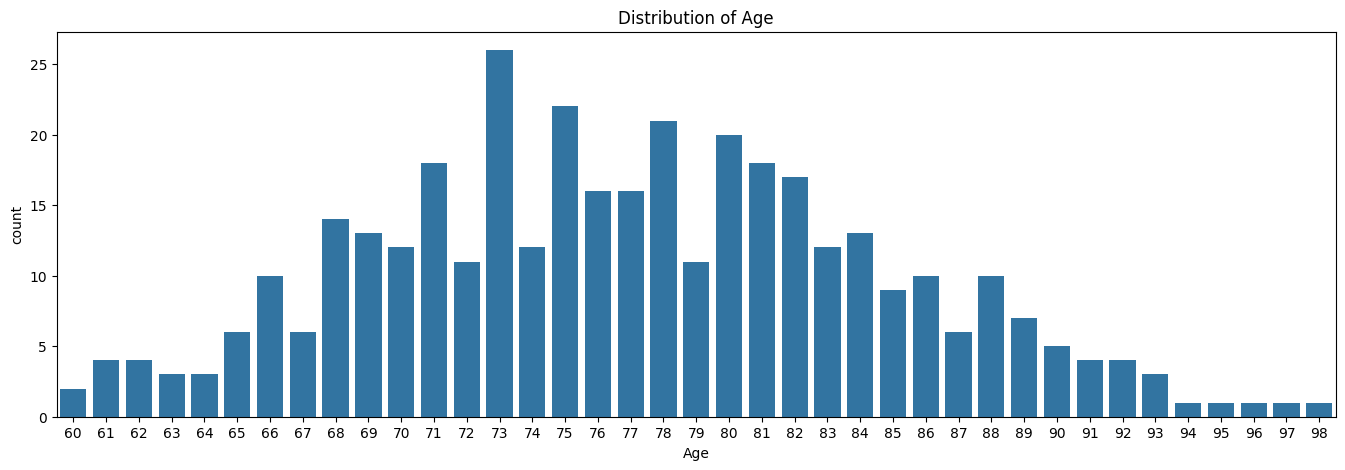

In [9]:
ax = sns.countplot(x='Age', data=df)
ax.figure.set_size_inches(16.5, 5)
ax.set_title("Distribution of Age")
plt.show()

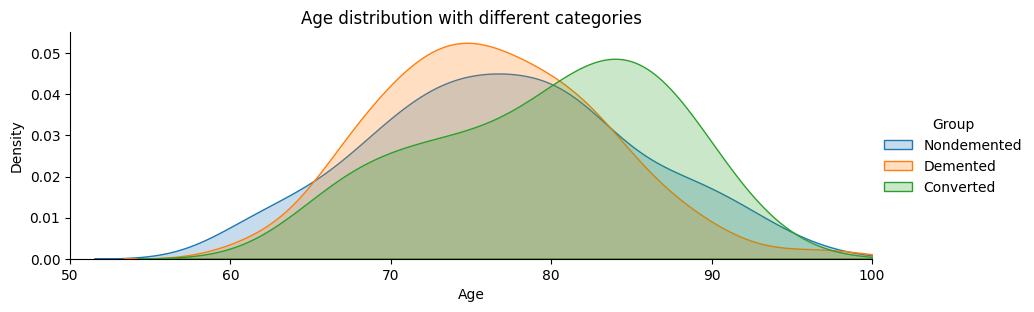

In [10]:
facet = sns.FacetGrid(df, hue="Group", aspect=3)
facet.map(sns.kdeplot, 'Age', fill=True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50, 100)
plt.title("Age distribution with different categories")
plt.show()

## MRI SCANS DATA

#### Downloading Data directly from the OASIS website

In [11]:
!wget https://download.nrg.wustl.edu/data/OAS2_RAW_PART1.tar.gz

--2024-04-03 04:58:17--  https://download.nrg.wustl.edu/data/OAS2_RAW_PART1.tar.gz
Resolving download.nrg.wustl.edu (download.nrg.wustl.edu)... 128.252.217.126
Connecting to download.nrg.wustl.edu (download.nrg.wustl.edu)|128.252.217.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10874461059 (10G) [application/x-gzip]
Saving to: ‘OAS2_RAW_PART1.tar.gz’

OAS2_RAW_PART1.tar. 100%[===================>]  10.13G  25.4MB/s    in 6m 16s  

2024-04-03 05:04:33 (27.6 MB/s) - ‘OAS2_RAW_PART1.tar.gz’ saved [10874461059/10874461059]



In [12]:
#unzipping
!tar -xf /content/OAS2_RAW_PART1.tar.gz

In [13]:
!rm /content/OAS2_RAW_PART1.tar.gz

In [14]:
!wget https://download.nrg.wustl.edu/data/OAS2_RAW_PART2.tar.gz

--2024-04-03 05:10:27--  https://download.nrg.wustl.edu/data/OAS2_RAW_PART2.tar.gz
Resolving download.nrg.wustl.edu (download.nrg.wustl.edu)... 128.252.217.126
Connecting to download.nrg.wustl.edu (download.nrg.wustl.edu)|128.252.217.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8449289603 (7.9G) [application/x-gzip]
Saving to: ‘OAS2_RAW_PART2.tar.gz’

OAS2_RAW_PART2.tar. 100%[===================>]   7.87G  27.4MB/s    in 5m 0s   

2024-04-03 05:15:28 (26.8 MB/s) - ‘OAS2_RAW_PART2.tar.gz’ saved [8449289603/8449289603]



In [15]:
!tar -xf /content/OAS2_RAW_PART2.tar.gz

In [16]:
!rm /content/OAS2_RAW_PART2.tar.gz

In [18]:
import shutil
source_dir = '/content/OAS2_RAW_PART2'
destination_dir = '/content/OAS2_RAW_PART1'

# Get list of files in source directory
files = os.listdir(source_dir)

# Move each file to the destination directory
for file in files:
    source_file_path = os.path.join(source_dir, file)
    destination_file_path = os.path.join(destination_dir, file)
    shutil.move(source_file_path, destination_file_path)

print("Files moved successfully!")

Files moved successfully!


In [19]:
!rm -r /content/OAS2_RAW_PART2

#### Plotting few Nifit files

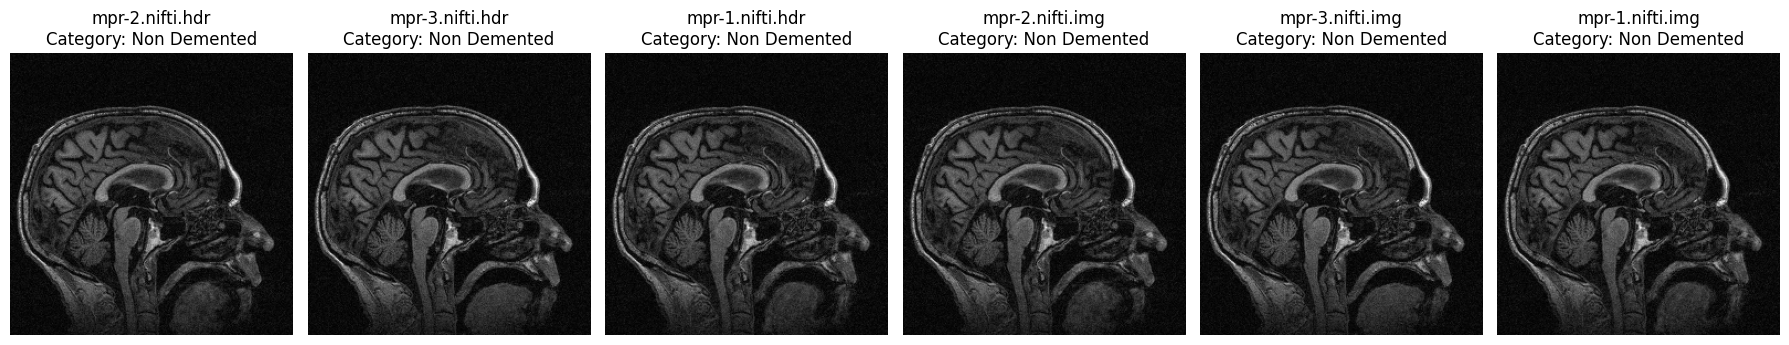

In [20]:
directory = "/content/OAS2_RAW_PART1/OAS2_0001_MR1/RAW"
image_files = [file for file in os.listdir(directory)]

# Create a 1x6 subplot for the 6 images
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 5))

# Iterate through the image files and plot each rotated image
for i, img_file in enumerate(image_files):
    img_path = os.path.join(directory, img_file)

    # Extract MRI ID from the parent folder name
    mri_id = os.path.basename(os.path.dirname(directory))

    # Find corresponding row in DataFrame
    matching_row = df[df['MRI ID'] == mri_id]
    if not matching_row.empty:
        # Extract category from 'Actual Group' column
        category = matching_row.iloc[0]['Actual Group']
    else:
        category = "Unknown"

    img = nib.load(img_path)
    img_data = img.get_fdata()

    # Rotate the image 90 degrees counterclockwise
    rotated_img_data = np.rot90(img_data)
    # Display the rotated image in the subplot
    axes.flat[i].imshow(rotated_img_data[:, :, img_data.shape[2]//2], cmap='gray')  # Displaying a central slice
    axes.flat[i].set_title(f"{img_file}\nCategory: {category}")
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()

#### Formatting the Data into simpler form by removing unnecesssay files, folder and renaming in proper format while reffering to the demographics data.

In [21]:
import shutil
source_directory = "/content/OAS2_RAW_PART1"
destination_directory = "/content/Data"

# Iterate through each folder in the source directory
for root, dirs, files in os.walk(source_directory):
    for dir_name in dirs:
        # Check if the directory contains a RAW folder
        raw_directory = os.path.join(root, dir_name, "RAW")
        if os.path.exists(raw_directory):
            # Get the new name from the parent folder name
            new_name = os.path.basename(os.path.dirname(raw_directory))

            # Create destination directory if it doesn't exist
            if not os.path.exists(destination_directory):
                os.makedirs(destination_directory)

            # Iterate through each file in the RAW folder
            for filename in os.listdir(raw_directory):
                # Rename and copy image files to the destination directory
                if filename.endswith(".img") or filename.endswith(".hdr"):
                    # Get the file extension
                    file_ext = os.path.splitext(filename)[1]
                    # Construct new filename with nifti included
                    new_filename = f"{new_name}_{filename.split('-')[1].split('.')[0]}.nifti{file_ext}"
                    # Copy and rename the file
                    shutil.copy2(os.path.join(raw_directory, filename), os.path.join(destination_directory, new_filename))
                    # Delete the original file
                    os.remove(os.path.join(raw_directory, filename))

In [22]:
!rm -r /content/OAS2_RAW_PART1

#### Plotting few files randomly and their categories by matching it with the MRI ID in demographic data.


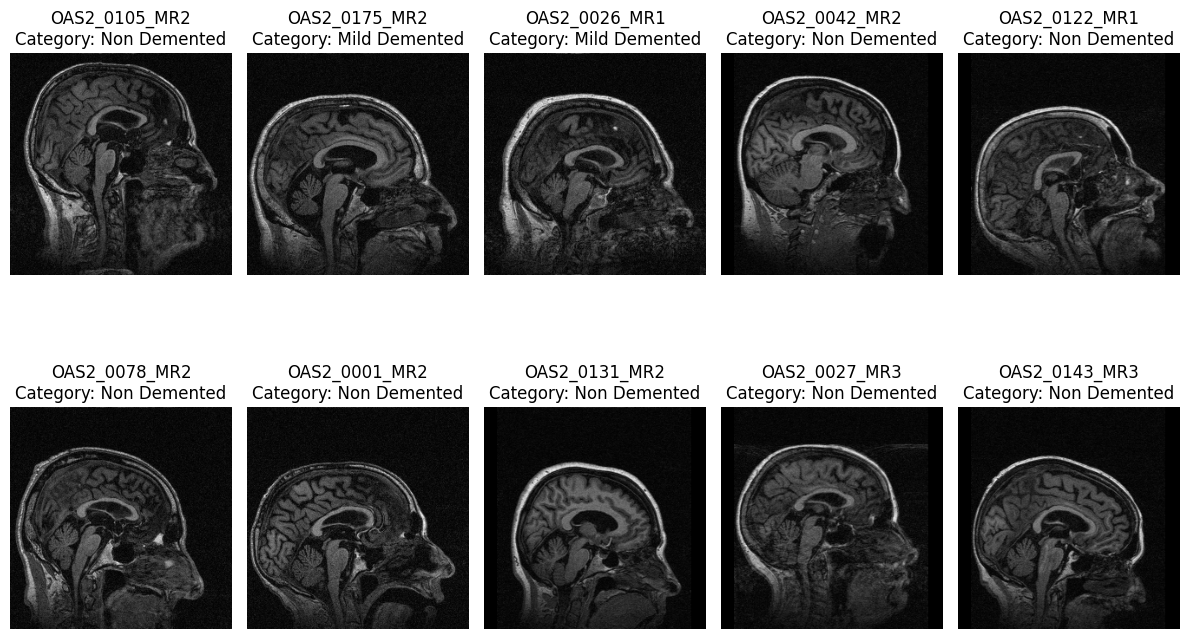

In [23]:
data_directory = "/content/Data"
data_image_files = os.listdir(data_directory)
random_image_files = random.sample(data_image_files, 10)

# Create a 2x5 subplot for the 10 images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))

# Iterate through the randomly selected image files and plot each one
for i, img_file in enumerate(random_image_files):
    img_path = os.path.join(data_directory, img_file)

    # Extract MRI ID from the first 13 characters of the image file name
    mri_id = img_file[:13]

    # Find corresponding row in DataFrame
    matching_row = df[df['MRI ID'] == mri_id]
    if not matching_row.empty:
        # Extract category from 'Actual Group' column
        category = matching_row.iloc[0]['Actual Group']
    else:
        category = "Unknown"

    img = nib.load(img_path)
    img_data = img.get_fdata()

    # Rotate the image 90 degrees counterclockwise
    rotated_img_data = np.rot90(img_data)

    # Display the image in the subplot
    axes.flat[i].imshow(rotated_img_data[:, :, img_data.shape[2]//2], cmap='gray')  # Displaying a central slice
    axes.flat[i].set_title(f"{mri_id}\nCategory: {category}")
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()

#### Formatting the files by putting it in folders respective to their categories while reffering to the demographics data.

In [24]:
data_directory = "/content/Data"

# Iterate through each file in the data directory
for file_name in os.listdir(data_directory):
    file_path = os.path.join(data_directory, file_name)

    # Extract MRI ID from the first 13 characters of the file name
    mri_id = file_name[:13]

    # Find corresponding row in DataFrame
    matching_row = df[df['MRI ID'] == mri_id]
    if not matching_row.empty:
        # Extract category from 'Actual Group' column
        category = matching_row.iloc[0]['Actual Group']

        # Create category directory if it doesn't exist
        category_directory = os.path.join(data_directory, category)
        if not os.path.exists(category_directory):
            os.makedirs(category_directory)

        # Move the file to the category directory
        new_file_path = os.path.join(category_directory, file_name)
        shutil.move(file_path, new_file_path)

#### Plotting different slices of images to select the final slice values.

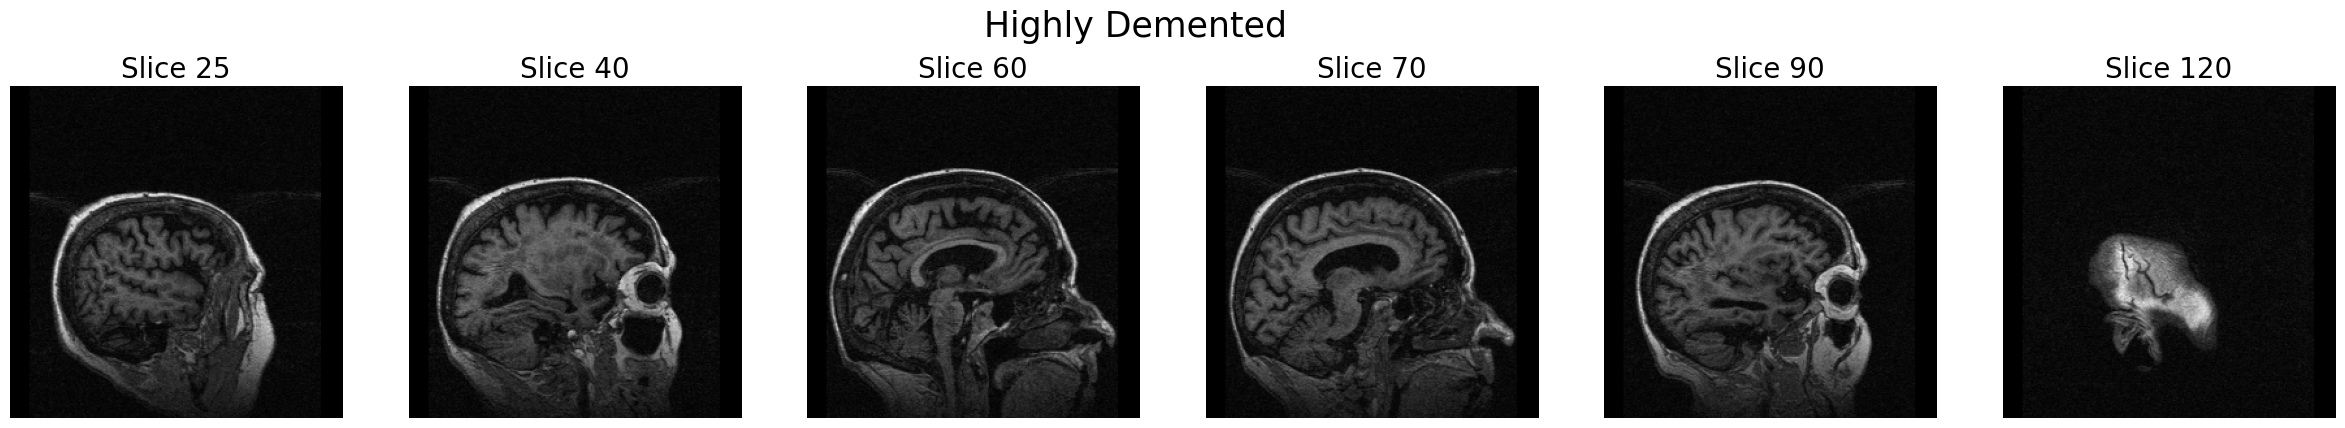

In [25]:
# Function to process a single NIfTI file
def process_nifti_file(file_path, slice_indices,title):
    img = nib.load(file_path)
    mri_images_data = img.get_fdata()
    # Transpose the data for visualization (adjusted for your array's shape)
    i = np.transpose(mri_images_data, (1, 0, 2, 3))

    # Get the filename without extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # Create the figure and subplots
    fig, axs = plt.subplots(1, len(slice_indices), figsize=(5 * len(slice_indices), 5))

    # Plot each slice
    for idx, slice_idx in enumerate(slice_indices):
        # Extract the slice data
        slice_data = i[:, :, slice_idx, 0]
        # Plot the slice on the corresponding subplot
        axs[idx].imshow(slice_data, origin='lower', cmap='gray')
        axs[idx].set_title(f'Slice {slice_idx}', fontsize=20)
        axs[idx].axis('off')

    # Add overall title
    plt.suptitle(title, fontsize=25)
    plt.show()

# File path
file_path = '/content/Data/Highly Demented/OAS2_0087_MR2_1.nifti.hdr'

# List of slice indices to extract
slice_indices = [25, 40, 60, 70, 90, 120]

# Process the specified file
process_nifti_file(file_path, slice_indices,"Highly Demented")

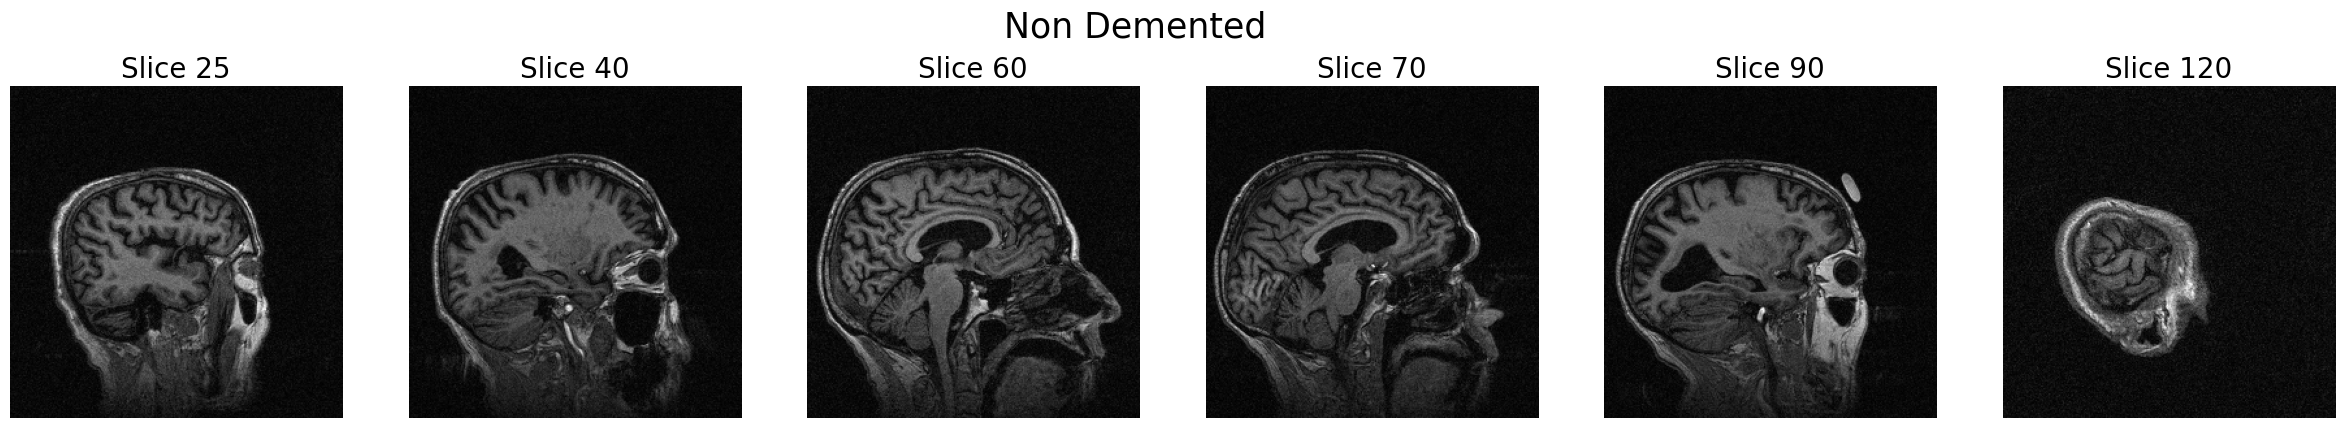

In [26]:
# File path
file_path = '/content/Data/Non Demented/OAS2_0001_MR1_1.nifti.hdr'

# List of slice indices to extract
slice_indices = [25, 40, 60, 70, 90, 120]

# Process the specified file
process_nifti_file(file_path, slice_indices, "Non Demented")

#### Plotting different axes of same files with different slices.

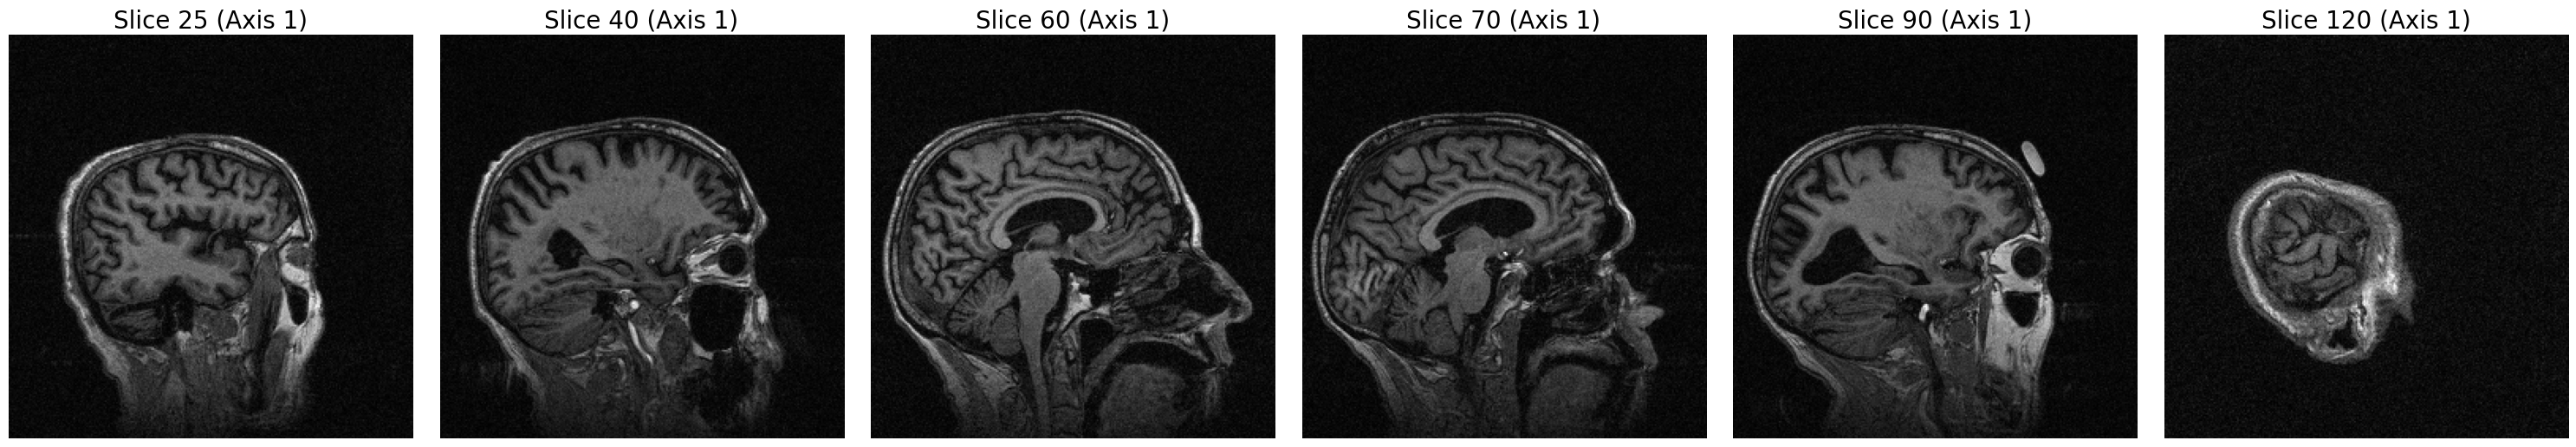

In [27]:
# Function to process a single NIfTI file
def process_nifti_file(file_path, slice_indices, slicing_method):
    img = nib.load(file_path)
    mri_images_data = img.get_fdata()
    # Transpose the data for visualization (adjusted for your array's shape)
    i = np.transpose(mri_images_data, (1, 0, 2, 3))

    # Get the filename without extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # Create the figure and subplots
    fig, axs = plt.subplots(1, len(slice_indices), figsize=(5 * len(slice_indices), 5))

    # Plot each slice
    for idx, slice_idx in enumerate(slice_indices):
        # Extract the slice data based on the specified method
        if slicing_method == 'Axis 1':
            slice_data = i[:, :, slice_idx, 0]
        elif slicing_method == 'Axis 2':
            slice_data = i[slice_idx, :, :, 0]
        elif slicing_method == 'Axis 3':
            slice_data = i[:, slice_idx, :, 0]
        else:
            raise ValueError("Invalid slicing method.")

        # Plot the slice on the corresponding subplot
        axs[idx].imshow(slice_data, origin='lower', cmap='gray')
        axs[idx].set_title(f'Slice {slice_idx} ({slicing_method})', fontsize=20)
        axs[idx].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# File path
file_path = '/content/Data/Non Demented/OAS2_0001_MR1_1.nifti.hdr'

# List of slice indices to extract
slice_indices = [25, 40, 60, 70, 90, 120]

# Slice method options
slicing_methods = ['Axis 1', 'Axis 2', 'Axis 3']

process_nifti_file(file_path, slice_indices, slicing_methods[0])

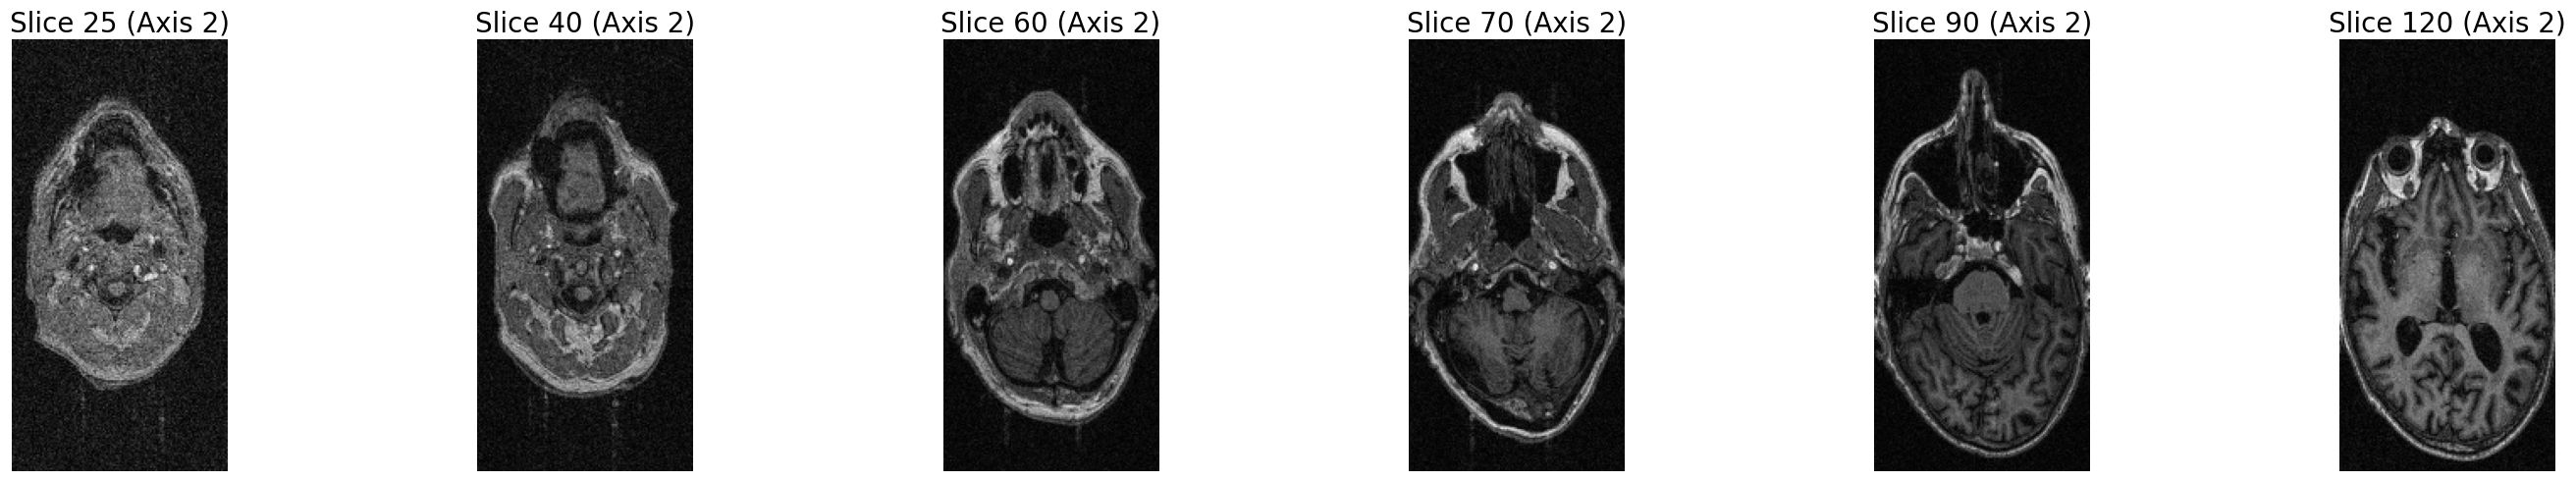

In [28]:
process_nifti_file(file_path, slice_indices, slicing_methods[1])

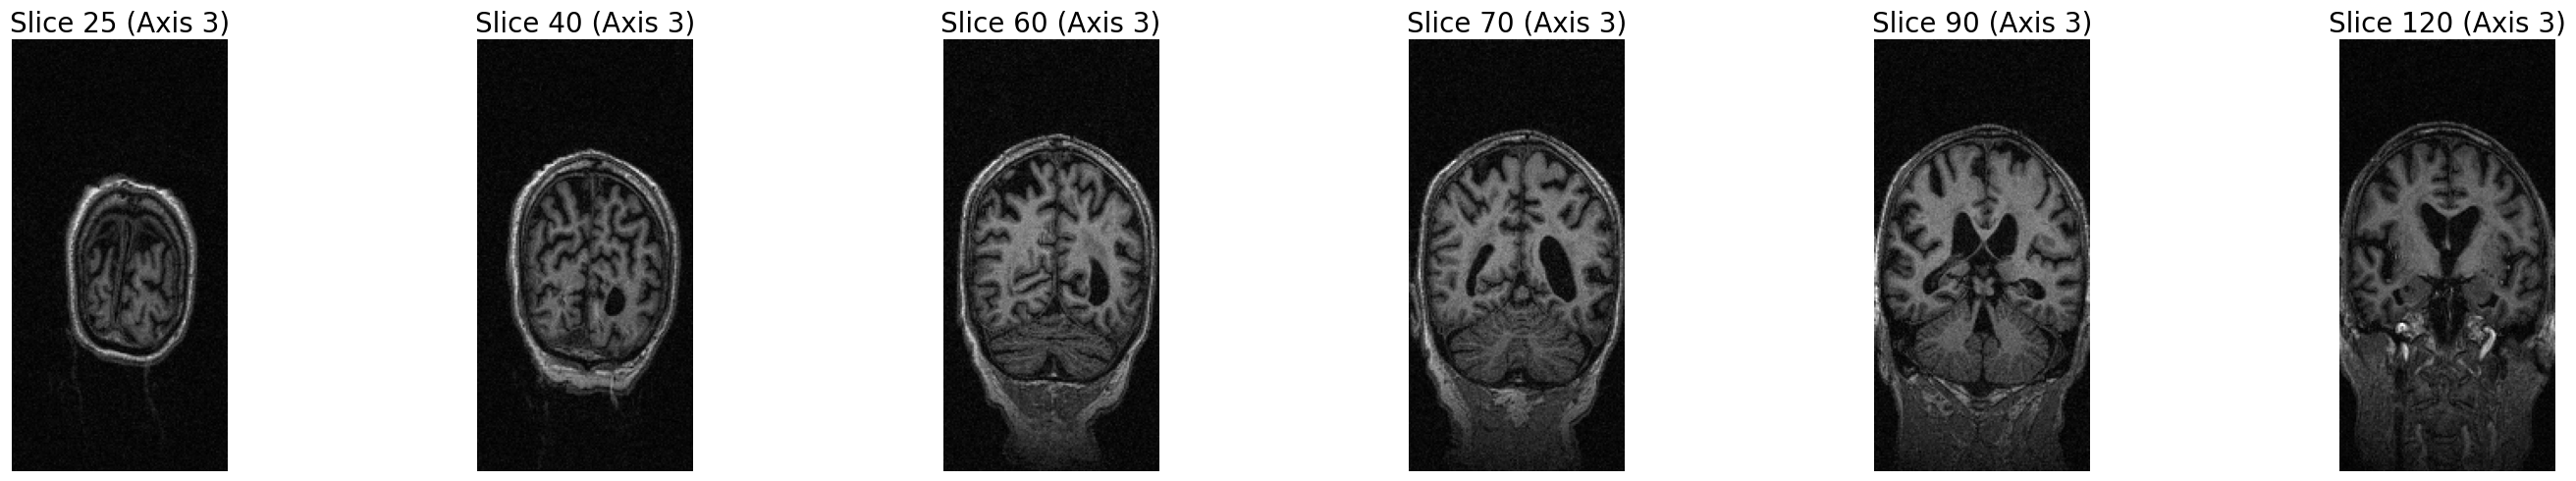

In [29]:
process_nifti_file(file_path, slice_indices, slicing_methods[2])

#### Saving the final slices and axes for Image Pre-processing and Modelling

In [6]:
# Function to process a single NIfTI file
def process_nifti_file(file_path):
    img = nib.load(file_path)
    mri_images_data = img.get_fdata()

    # Transpose the data for visualization (adjusted for your array's shape)
    i = np.transpose(mri_images_data, (1, 0, 2, 3))

    # Get the filename without extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    for idx in slice_indices:
        # Create the figure and subplot
        plt.figure(figsize=(15, 5))
        f = i[:, :, idx, 0]

        # Display the slice
        plt.imshow(f, origin='lower')

        # Save the slice as a JPG file
        slice_file_name = f"{file_name}_{idx}.jpg"
        plt.axis('off')
        plt.savefig(os.path.join(os.path.dirname(file_path), slice_file_name), bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the current figure to avoid displaying it

# Directory containing the data
data_directory = '/content/Data'

# List of slice indices to extract
slice_indices = [62, 65, 68, 70, 72]

# Iterate through each folder and process the files
for root, dirs, files in os.walk(data_directory):
    for file in files:
        if file.endswith(".nifti.hdr"):
            file_path = os.path.join(root, file)
            process_nifti_file(file_path)
            # Delete the original NIfTI files
            os.remove(file_path)

#### Removing Unnecessary files

In [7]:
import os
def remove_and_rename_files(directory):
    # Iterate through each folder and its contents
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nifti.img'):
                # Remove files ending with '.nifti.img'
                os.remove(os.path.join(root, file))
            else:
                # Rename files containing '.nifti' to contain 'slice' instead
                if '.nifti' in file:
                    new_name = file.replace('.nifti', 'slice')
                    os.rename(os.path.join(root, file), os.path.join(root, new_name))

# Directory containing the data
data_directory = '/content/Data'

# Remove files ending with '.nifti.img' and rename files containing '.nifti'
remove_and_rename_files(data_directory)

print("Files removed and renamed successfully.")

Files removed and renamed successfully.


#### Preprocessing

In [8]:
import pathlib
file_path = '/content/Data'
data_dir = pathlib.Path(file_path)

# Get the class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Highly Demented' 'Mild Demented' 'Moderate Demented' 'Non Demented']


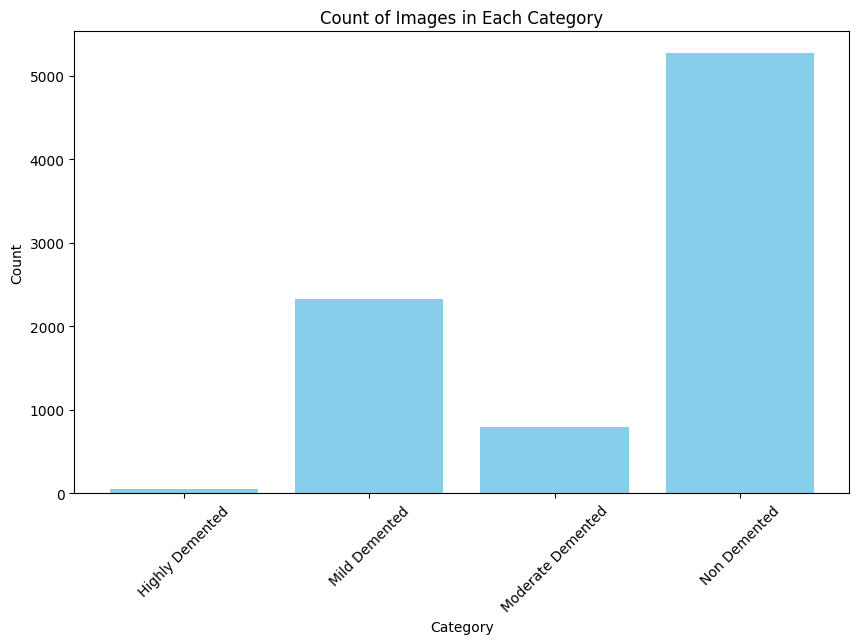

In [9]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

# Count the number of images in each class
class_counts = []
for class_name in class_names:
    class_counts.append(len(list(data_dir.glob(f"{class_name}/*"))))

# Plot the count of each category
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Images in Each Category')
plt.xticks(rotation=45)
plt.show()

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to the data folders
data_folder = '/content/Data'
categories = ['Highly Demented', 'Mild Demented', 'Moderate Demented', 'Non Demented']

# Define target number of images
target_count = 4300

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Iterate over each category
for category in categories:
    category_folder = os.path.join(data_folder, category)
    images = os.listdir(category_folder)
    num_images = len(images)

    # Check if the category needs augmentation
    if num_images < target_count:
        print(f'Augmenting images for {category}...')
        # Calculate the number of additional images needed
        augment_count = target_count - num_images
        print(f'Augmenting {augment_count} images...')
        augment_iter = datagen.flow_from_directory(
            data_folder,
            target_size=(150, 150),
            classes=[category],
            batch_size=1,
            class_mode=None,
            shuffle=True,
            save_to_dir=category_folder,
            save_prefix='aug_',
            save_format='jpg'
        )
        # Generate and save additional images
        for i in range(augment_count):
            augment_batch = augment_iter.next()

Augmenting images for Highly Demented...
Augmenting 4945 images...
Found 55 images belonging to 1 classes.
Augmenting images for Mild Demented...
Augmenting 2674 images...
Found 2326 images belonging to 1 classes.
Augmenting images for Moderate Demented...
Augmenting 4205 images...
Found 795 images belonging to 1 classes.


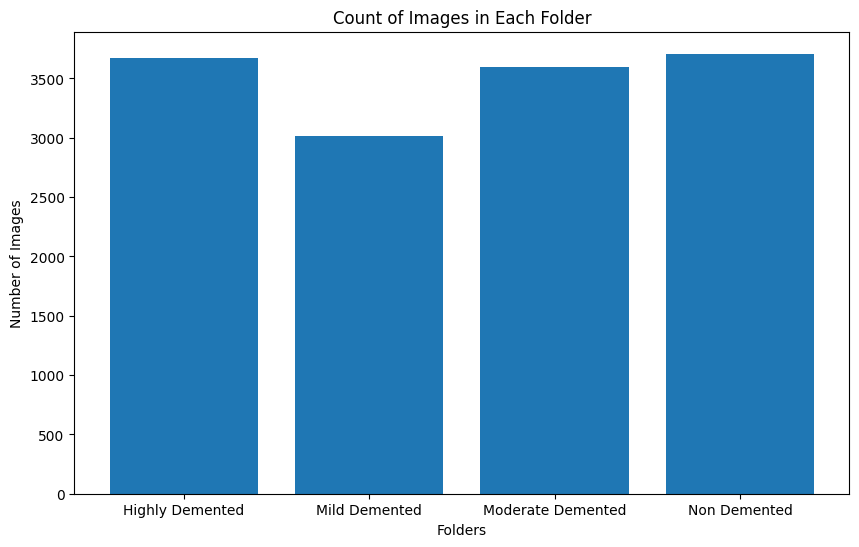

In [7]:
file_path = '/content/Data'

# List of folders to process
folders = ['Highly Demented', 'Mild Demented', 'Moderate Demented', 'Non Demented']

# List to store counts
counts = []

# Loop through each folder and count images
for folder in folders:
    folder_path = os.path.join(file_path, folder)
    counts.append(len(os.listdir(folder_path)))

# Plot count of each folder
plt.figure(figsize=(10, 6))
plt.bar(range(len(folders)), counts)
plt.xlabel('Folders')
plt.ylabel('Number of Images')
plt.title('Count of Images in Each Folder')
plt.xticks(range(len(folders)), folders)
plt.show()

In [8]:
file_path = "/content/Data"
data = tf.keras.utils.image_dataset_from_directory(file_path,
                                                batch_size = 32,
                                                image_size=(385, 385),
                                                shuffle=True,
                                                seed=42,)
class_names = data.class_names

Found 13989 files belonging to 4 classes.


In [9]:
import matplotlib.pyplot as plt

def preprocess_data(data):
    # Normalize pixel values
    normalized_data = data.map(lambda x, y: (x / 255, y))
    return normalized_data

def create_new_batch(data):
    batch = next(iter(data))
    images, labels = batch
    images_np = images.numpy()
    labels_np = labels.numpy()
    print("Min and max pixel values in the batch ->", images_np.min(), "&", images_np.max())
    return images_np, labels_np

def show_batch_images(images, labels, label_names, number_of_images=5):
    fig, axes = plt.subplots(1, number_of_images, figsize=(20, 20))
    fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", fontsize=18, fontweight='bold', y=0.6)
    for i, (image, label) in enumerate(zip(images[:number_of_images], labels[:number_of_images])):
        axes[i].imshow(image)
        axes[i].set_title(label_names[label])  # Use label_names to map label to its original name
        axes[i].axis('off')

def process_data(data, number_of_images=5):
    preprocessed_data = preprocess_data(data)
    images, labels = create_new_batch(preprocessed_data)
    label_names = {index: img for index, img in enumerate(data.class_names)}  # Create label names dictionary
    show_batch_images(images, labels, label_names, number_of_images)
    return preprocess_data

Min and max pixel values in the batch -> 0.0 & 0.99849


<function __main__.preprocess_data(data)>

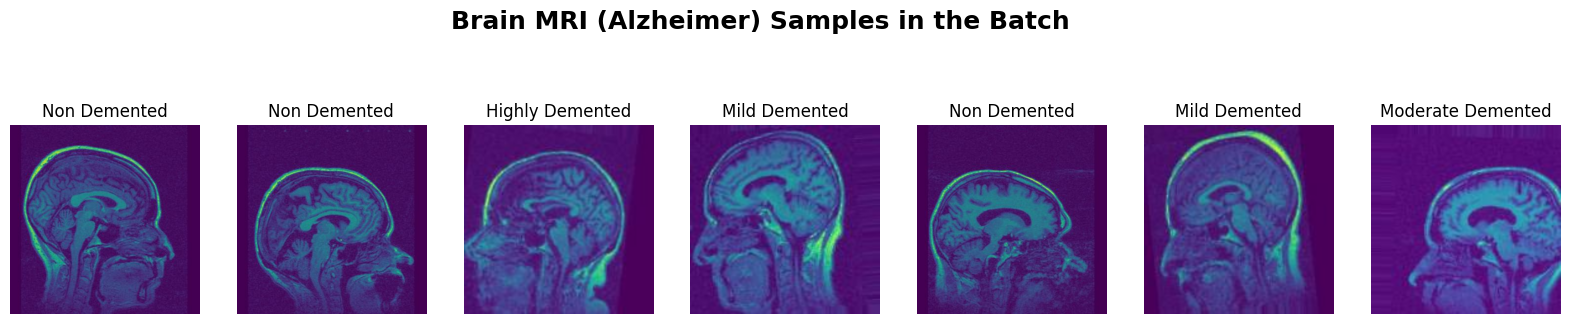

In [10]:
process_data(data, number_of_images=7)

#### Train Test Split

In [11]:
def train_test_val_split(data, train_size, val_size, test_size):
    train = int(len(data) * train_size)
    val = int(len(data) * val_size)
    test = int(len(data) * test_size)

    train_data = data.take(train)
    val_data = data.skip(train).take(val)
    test_data = data.skip(train + val).take(test)

    return train_data, val_data, test_data
train_data, val_data, test_data = train_test_val_split(data, train_size=0.8, val_size=0.1, test_size=0.1)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [13]:
model = None
history = None

#### Modelling

In [14]:

def build_simple_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dropout(0.125))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.125))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model.summary()

    return model

# Input shape should match your data shape (e.g., (385, 385, 3))
input_shape = (385, 385, 3)

# Build the simple CNN model
model = build_simple_cnn_model(input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 383, 383, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 191, 191, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 189, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 94, 94, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 92, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 46, 46, 128)       0

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def checkpoint_callback():
    checkpoint_filepath = '/temp/cp'
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 verbose=1)
    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback

EPOCHS = 30
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [17]:
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, callbacks=callbacks)

Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 69.4300 - accuracy: 0.5733
Epoch 1: val_accuracy improved from -inf to 0.74782, saving model to /temp/cp
350/350 [==============================] - 94s 239ms/step - loss: 69.4300 - accuracy: 0.5733 - val_loss: 0.6285 - val_accuracy: 0.7478
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.7792
Epoch 2: val_accuracy improved from 0.74782 to 0.78343, saving model to /temp/cp
350/350 [==============================] - 83s 236ms/step - loss: 0.5574 - accuracy: 0.7792 - val_loss: 0.5234 - val_accuracy: 0.7834
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8712
Epoch 3: val_accuracy improved from 0.78343 to 0.80233, saving model to /temp/cp
350/350 [==============================] - 61s 172ms/step - loss: 0.3318 - accuracy: 0.8712 - val_loss: 0.5007 - val_accuracy: 0.8023
Epoch 4/30
350/350 [==============================] - ETA: 0s - loss

#### Analysis

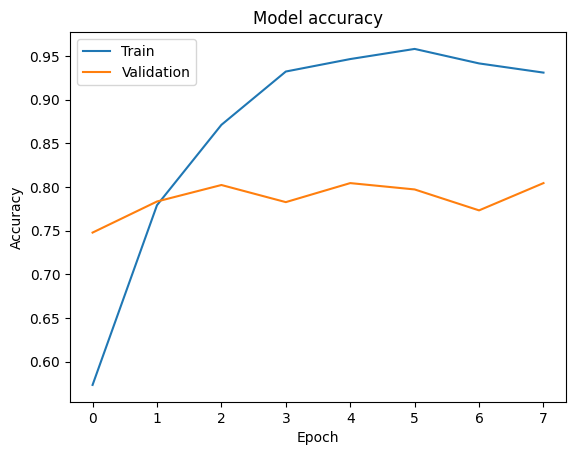

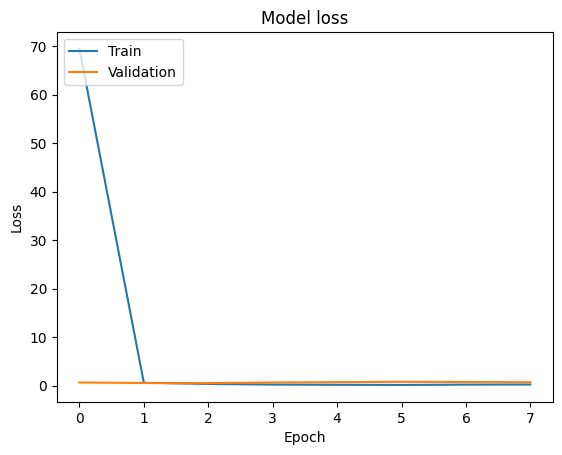

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
model.evaluate(test_data)

43/43 [==============================] - 20s 58ms/step - loss: 0.7826 - accuracy: 0.7594


[0.7825790047645569, 0.7594476938247681]

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                   precision    recall  f1-score   support

  Highly Demented       0.73      0.81      0.77       346
    Mild Demented       0.67      0.57      0.62       310
Moderate Demented       0.63      0.66      0.64       353
     Non Demented       0.98      0.96      0.97       367

         accuracy                           0.76      1376
        macro avg       0.75      0.75      0.75      1376
     weighted avg       0.76      0.76      0.76      1376



In [21]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df

Highly Demented  Mild Demented  Moderate Demented  \
Highly Demented                280             22                 44   
Mild Demented                   38            178                 89   
Moderate Demented               65             55                232   
Non Demented                     0             10                  4   

                   Non Demented  
Highly Demented               0  
Mild Demented                 5  
Moderate Demented             1  
Non Demented                353

Text(70.7222222222222, 0.5, 'True')

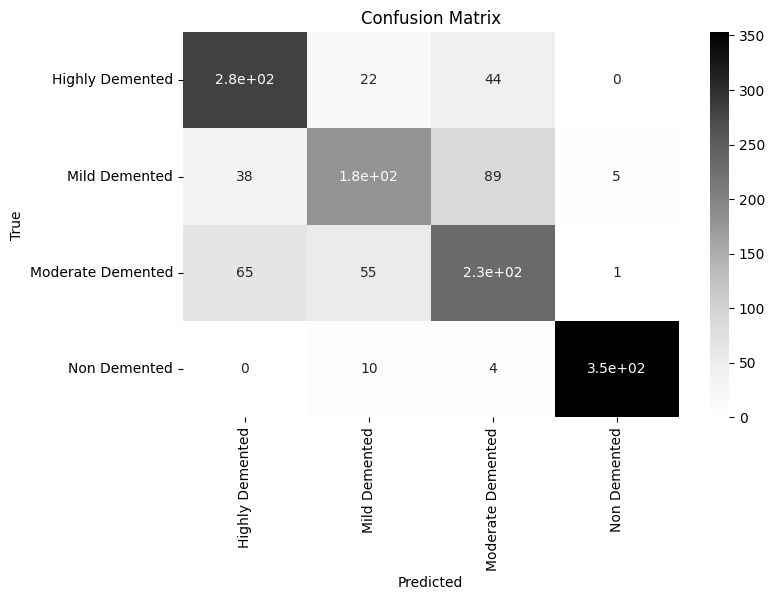

In [22]:
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, cmap="Greys")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

1/1 [==============================] - 0s 70ms/step


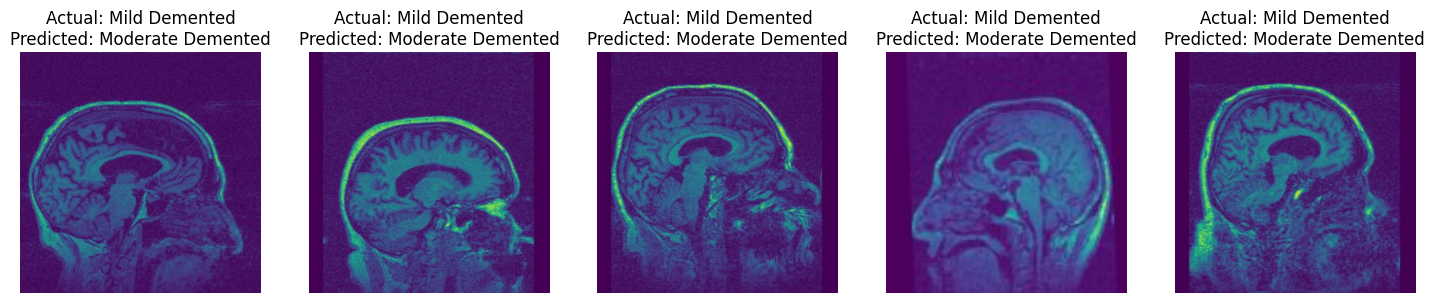

In [24]:
def plot_images_with_labels(test_data, model, class_names):
    plt.figure(figsize=(18, 15))
    for images, labels in test_data.take(1):
        # Scale pixel values to [0, 1]
        images = images / 255.0
        # Predict labels for the images
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        # Filter images and labels for 'Very_Mild_Demented' category
        mild_demented_mask = labels.numpy() == class_names.index('Mild Demented')
        images_mild_demented = images.numpy()[mild_demented_mask]
        labels_mild_demented = labels.numpy()[mild_demented_mask]
        predicted_labels_mild_demented = predicted_labels[mild_demented_mask]
        # Plot images
        num_images = min(5, len(images_mild_demented))
        for i in range(num_images):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images_mild_demented[i])
            plt.title(f'Actual: {class_names[labels_mild_demented[i]]}\nPredicted: {class_names[predicted_labels_mild_demented[i]]}')
            plt.axis('off')

# Plot images with predicted labels for 'Very_Mild_Demented' category
plot_images_with_labels(test_data, model, class_names)
plt.show()

#### VGG 16

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_vgg16_model(input_shape, num_classes):
    # Load the pre-trained VGG16 model without the top (classification) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.125)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.125)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the input shape and number of classes
input_shape = (385, 385, 3)
num_classes = 4

# Build the VGG16 model with fine-tuning
vgg16_model = build_vgg16_model(input_shape, num_classes)

# Print model summary
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 385, 385, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 385, 385, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 385, 385, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 192, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 96, 128)       0   

In [34]:
def checkpoint_callback():
    checkpoint_filepath = '/temp/cp'
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 verbose=1)
    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback

# Define number of epochs and callbacks
EPOCHS = 30
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = vgg16_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 2.9952 - accuracy: 0.4997
Epoch 1: val_accuracy improved from -inf to 0.51672, saving model to /temp/cp
350/350 [==============================] - 184s 522ms/step - loss: 2.9952 - accuracy: 0.4997 - val_loss: 0.9966 - val_accuracy: 0.5167
Epoch 2/30
267/350 [=====================>........] - ETA: 33s - loss: 0.9031 - accuracy: 0.6365